# Experiment: number of pointer moves

** Objective: ** Verify that the maximum number of moves required to insert a new point in the piecewise function is of the order of $O(\log n)$, where $n$ is the number of examples in a dataset.

In [189]:
%matplotlib inline
from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns; sns.set_style("white")

from mmit import MaxMarginIntervalTree
from mmit.core.solver import compute_optimal_costs
from mmit.model_selection import GridSearchCV
from os import listdir
from os.path import abspath, basename, exists, join

## Data loading

In [190]:
class Dataset(object):
    def __init__(self, path):
        self.path = path
        feature_data = pd.read_csv(join(path, "features.csv"))
        self.X = feature_data.values
        self.feature_names = feature_data.columns.values
        del feature_data
        self.y = pd.read_csv(join(path, "targets.csv")).values
        self.folds = pd.read_csv(join(path, "folds.csv")).values.reshape(-1, )
        self.name = basename(path)
    
    @property
    def n_examples(self):
        return self.y.shape[0]
    
def find_datasets(path):
    for d in listdir(path):
        if exists(join(path, d, "features.csv")) and \
           exists(join(path, d, "targets.csv")) and \
           exists(join(path, d, "folds.csv")):
            yield Dataset(abspath(join(path, d)))

## Experiment

In [191]:
def experiment_pointer_moves(dataset, loss):
    n_repeats = 10
    loss_codes = dict(linear_hinge=0, squared_hinge=1)
    
    max_pointer_moves = []
    for _ in range(n_repeats):
        shuffler = np.arange(dataset.n_examples)
        np.random.shuffle(shuffler)
        y = dataset.y[shuffler]
        
        for epsilon in np.logspace(-3, 1, 100):
            pointer_moves, _, _ = \
                compute_optimal_costs(np.array([yi[0] for yi in y]), 
                                      np.array([yi[1] for yi in y]), 
                                      epsilon, loss_codes[loss])
            max_pointer_moves.append(max(pointer_moves))
    return max_pointer_moves

## Results

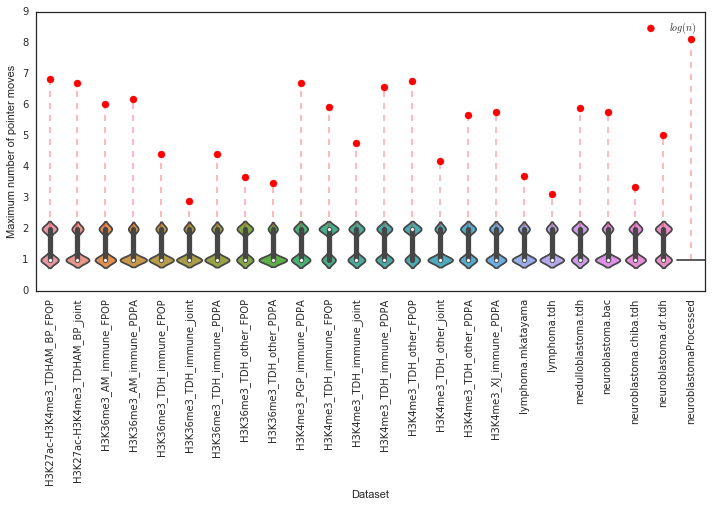

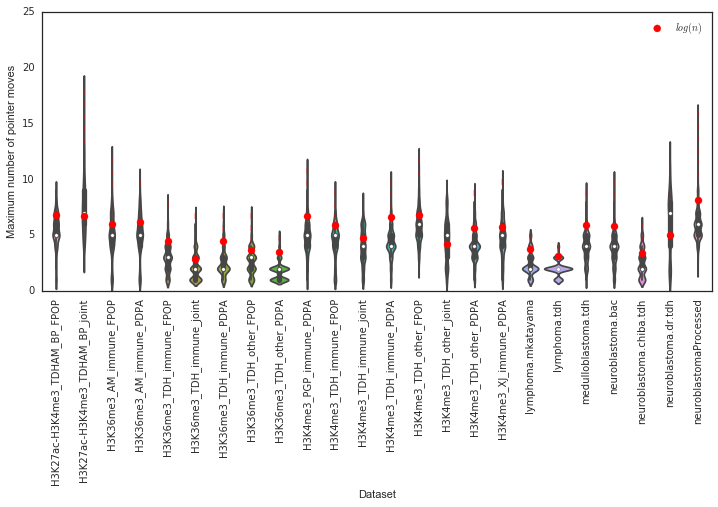

In [192]:
def plot_moves_distribution(datasets, moves_by_dataset, save_name):
    plt.clf()
    plt.gcf().set_size_inches(12, 5)
    
    # Convert to pandas dataset for seaborn plotting
    data = []
    for i, d in enumerate(datasets):
        for v in moves_by_dataset[i]:
            data.append([d.name, v])
    move_counts = pd.DataFrame(data, columns=["dataset", "max_pointer_moves"])

    # Plot the distribution of moves
    sns.violinplot(x="dataset", y="max_pointer_moves", data=move_counts, width=1.)
    plt.xticks(rotation=90)

    # Plot the log number of examples by dataset
    for i, d in enumerate(datasets):
        plt.vlines(ymin=max(moves_by_dataset[i]), ymax=np.log(d.n_examples), x=i, linestyles="--", color="red", alpha=0.3)
    
    plt.scatter(range(len(datasets)), [np.log(d.n_examples) for d in datasets], color="red", zorder=100, label="$log(n)$",
               s=50)

    # Plot formatting
    plt.ylabel("Maximum number of pointer moves")
    plt.xlabel("Dataset")
    plt.ylim(ymin=0)
    plt.legend()

    # Save it!
    plt.savefig(save_name, bbox_inches="tight")
    plt.show()

    
datasets = list(find_datasets("./data"))

linear_hinge_moves_by_dataset = np.array([experiment_pointer_moves(d, "linear_hinge") for d in datasets])
plot_moves_distribution(datasets, linear_hinge_moves_by_dataset, "linear_hinge_pointer_moves.pdf")

squared_hinge_moves_by_dataset = np.array([experiment_pointer_moves(d, "squared_hinge") for d in datasets])
plot_moves_distribution(datasets, squared_hinge_moves_by_dataset, "squared_hinge_pointer_moves.pdf")

## Conclusions

* Linear hinge loss: the number of pointer moves is constant on all datasets and varies between 1 and 2.
* Squared hinge loss: the number of pointer moves is not constant, but seems to be of the order of $log(n)$. It is definitely smaller than $n$ and thus, sublinear in the number of examples in the dataset.